## Problem Framing

Things we need to understand about the project:
1. How will the model be used?
2. Is the task supervised, unsupervised or reinforcement?
3. Is it classification or regression?
4. What does the current solution look like? What are its limitations?

## Select a Performance Measure

1. Root Mean Square Error
It measures the standard deviation of the errors made in the predictions. For example an RMSE of 100 means that about 68% of the predictions will fall within 100 of the actual value and 95% will fall within 200 of the actual value.

\begin{equation*}
\ RMSE=
\sqrt{\frac{1}{m}\sum{(h(x)-y)^2}}
\end{equation*}

2. Mean Absolute Error
In the case that there are a lot of outliers, we might want to use MAE instead. 
\begin{equation*}
\ MAE= \frac{1}{m}\sum{|(h(x)-y)|}
\end{equation*}



## Download the Data

In [7]:
import os
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [9]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

load_housing_data().head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
housing_data = load_housing_data()

In [11]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [12]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


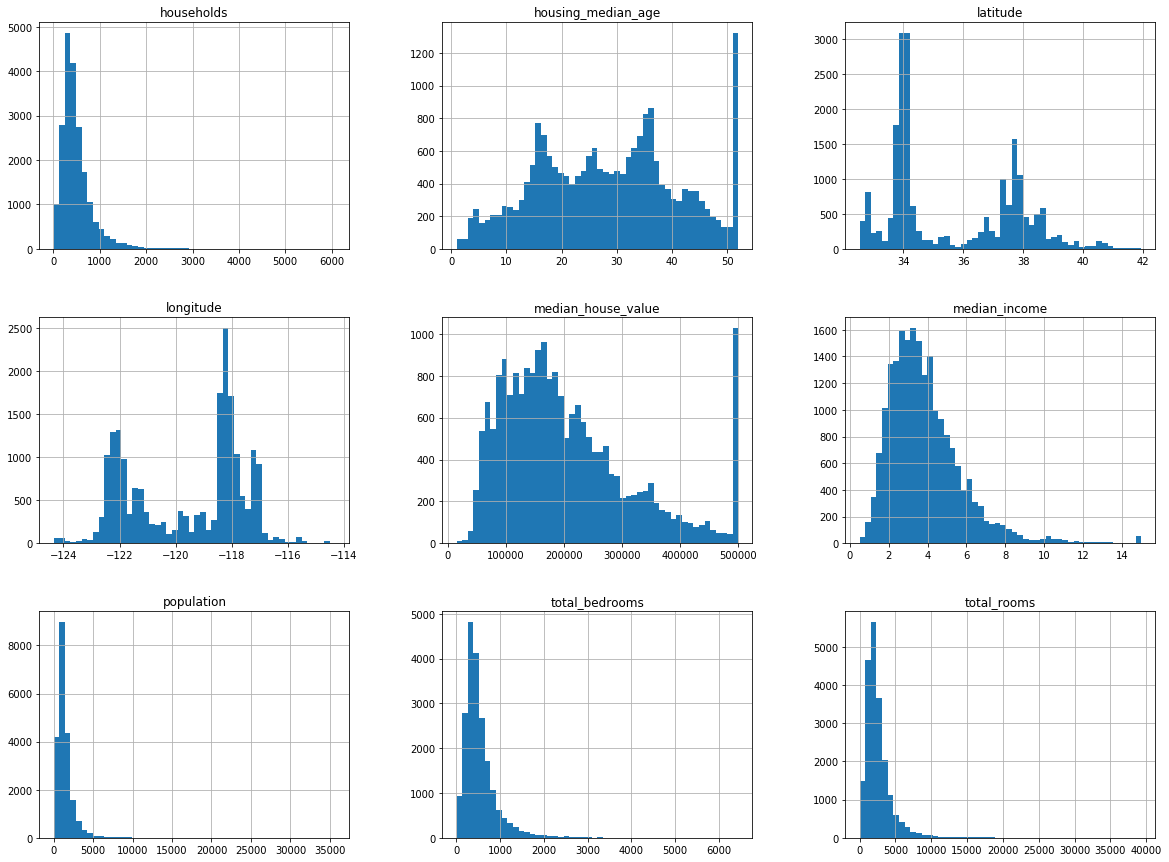

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
housing_data.hist(bins=50, figsize=(20,15))
plt.show()

Notice a few things in these histograms:
1. First, the median income attribute does not look like it is expressed in US dollars
(USD). After checking with the team that collected the data, you are told that the
data has been scaled and capped at 15 (actually 15.0001) for higher median
incomes, and at 0.5 (actually 0.4999) for lower median incomes. Working with
preprocessed attributes is common in Machine Learning, and it is not necessarily
a problem, but you should try to understand how the data was computed.
2. The housing median age and the median house value were also capped. The latter
may be a serious problem since it is your target attribute (your labels). Your
Machine Learning algorithms may learn that prices never go beyond that limit.
You need to check with your client team (the team that will use your system’s output)
to see if this is a problem or not. If they tell you that they need precise predictions
even beyond \\$500,000, then you have mainly two options:
    * Collect proper labels for the districts whose labels were capped.
    * Remove those districts from the training set (and also from the test set, since
your system should not be evaluated poorly if it predicts values beyond
\$500,000).
3. These attributes have very different scales. We will discuss this later in this chapter
when we explore feature scaling.
4. Finally, many histograms are tail heavy: they extend much farther to the right of
the median than to the left. This may make it a bit harder for some Machine
Learning algorithms to detect patterns. We will try

## Create a Test set

We need a test set and not look at it to make sure we don't affected by data snooping bias

In [19]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_data, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


Stratified Sampling to ensure that each strata of an important feature is adequately represnted

In [26]:
housing_data["income_cat"] = np.ceil(housing_data["median_income"] / 1.5)
housing_data["income_cat"].where(housing_data["income_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Visualizing Data

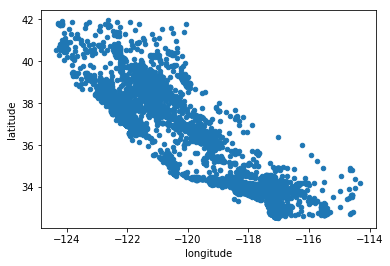

In [27]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")

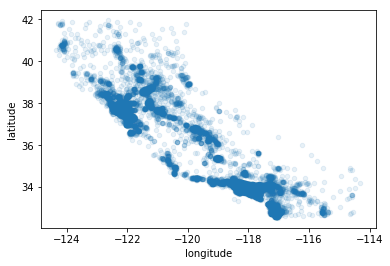

In [28]:
#Set alpha=0.1 to see places with higher density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

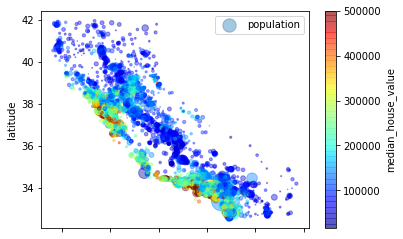

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population",
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

## Find Correlations between Features

In [31]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64